# Conditioning and Stability

In [1]:
import numpy as np
from numpy import linalg as LA
import sympy as sy
from matplotlib import pyplot as plt
from numba import vectorize, jit, njit, float64, prange
from scipy.linalg import solve_triangular
import math

### Problem 1

In [241]:
def conditional_number(A):
        
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    σ_max, σ_min = max(s), min(s)
    
    if σ_min == 0:
        return np.inf
    else:
        κ = σ_max / σ_min
        return κ

In [242]:
A = np.eye(3)
conditional_number(A)

1.0

In [243]:
np.linalg.cond(A)

1.0

### Problem 2

In [244]:
def perturb_wilkinson():
    
    ### Wilkinson Polynomial:
    w_roots = np.arange(1, 21)
    w_roots = np.sort(w_roots)
    
    x, i = sy.symbols('x i')
    w = sy.poly_from_expr(sy.product(x-i, (i, 1, 20)))[0]
    w_coeffs = np.array(w.all_coeffs())

    #fig = plt.figure(figsize=(8,10))
    plt.scatter(w_roots, np.zeros(len(w_roots)), marker='.', label='Original')
    plt.xlabel('Real Axis')
    plt.ylabel('Imaginary Axis')
    
    κ_abs_list = []
    κ_rel_list = []
    for j in range(100):
        h = np.random.normal(loc=1, scale=1e-10, size=len(w_coeffs))
        new_coeffs = w_coeffs * h
        new_roots = np.roots(np.poly1d(new_coeffs))
        new_roots = np.sort(new_roots)
        
        κ_abs = LA.norm(new_roots - w_roots, np.inf) / LA.norm(h, np.inf)
        κ_abs_list.append(κ_abs)
        κ_rel = κ_abs * LA.norm(w_coeffs, np.inf) / LA.norm(w_roots, np.inf)                     
        κ_rel_list.append(κ_rel)
                             
        reals = []
        imags = []
        for root in new_roots:
            reals.append(root.real)
            imags.append(root.imag)
        
        if j == 0:
            plt.scatter(reals, imags, color='black', linewidths=.5, marker='.', label='Perturbed', s=.4)
        else:
            plt.scatter(reals, imags, color='black', linewidths=.5, marker='.', s=.4)
        
    plt.legend(loc='upper left')
    plt.show();  
    
    return κ_abs_list, κ_rel_list

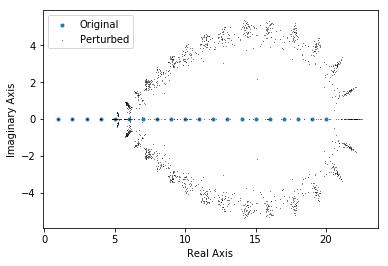

([5.00354329739887,
  4.8560515905854045,
  4.67851749248056,
  4.5264589820929855,
  4.506897601406215,
  4.745857341634202,
  4.572982568281113,
  5.1569806051921425,
  4.119360988468116,
  4.7923129526412085,
  5.215230756465441,
  5.481926999957142,
  4.109584690760479,
  5.05398199745543,
  5.327272160794425,
  5.0412148292698165,
  4.613567152603423,
  4.8443494738301425,
  3.960226785487392,
  5.023848605967551,
  5.007615449383421,
  4.7777669581771365,
  4.903052821806404,
  5.109603181946395,
  5.3015500681606245,
  5.140549790933957,
  4.924613258704633,
  4.624253894963577,
  4.819186563379578,
  5.41448396359619,
  4.164481026961885,
  4.96411171991374,
  4.989809649918771,
  5.070870995760806,
  4.705098002425986,
  4.912481910952071,
  4.9266626535984495,
  4.941464334588487,
  5.048009614641846,
  4.502246724216256,
  4.598929674900566,
  4.237062487056166,
  5.237070710665692,
  5.1872566621390295,
  4.793706462343176,
  5.103366902810569,
  4.490517588535239,
  4.7705

In [245]:
perturb_wilkinson()

### Problem 3

In [4]:
def condition_number(A):
    
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    
    λ = LA.eigvals(A)
    λ_hat = LA.eigvals(A + H)
    
    κ_hat = LA.norm(λ - λ_hat, 2) / LA.norm(H, 2)
    κ = LA.norm(A, 2) / LA.norm(λ, 2) * κ_hat
    
    return κ_hat, κ

### Problem 4

In [5]:
def prob4(bounds, res):
    x_min, x_max, y_min, y_max = bounds
    x_list = np.linspace(x_min, x_max, res)
    y_list = np.linspace(y_min, y_max, res)
    
    κ_matrix = np.zeros((res, res))
    for i in range(len(x_list)):
        for j in range(len(y_list)):
            x = x_list[i]
            y = y_list[j]
            A = np.array([[1, x], [y, 1]])
            κ_matrix[i, j] = condition_number(A)[1]
    
    plt.pcolormesh(x_list, y_list, κ_matrix, cmap='gray_r')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()  

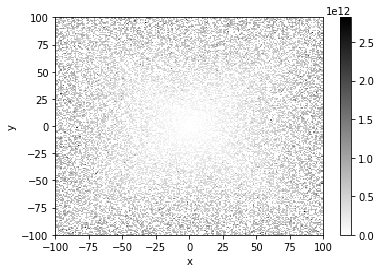

In [6]:
bounds = [-100, 100, -100, 100]
res = 200
prob4(bounds, res)

### Problem 5

In [278]:
def prob5(n):
    
    xk, yk = np.load("stability_data.npy").T
    A = np.vander(xk, n+1)
    b = yk
    x_normal = LA.inv(A.T @ A) @ A.T @ b
    
    Q, R = LA.qr(A)
    ## QRx = y
    ## Rx = (Q.T)y
    x_QR = solve_triangular(R, Q.T @ b)

    domain = np.linspace(0, 1, 100)
    y_normal = np.polyval(x_normal, xk)
    y_QR = np.polyval(x_QR, xk)

    plt.plot(domain, y_normal, label='Normal Equations')
    plt.plot(domain, y_QR, label='QR Solver')
    plt.scatter(xk, yk, s=2)
    plt.legend(loc='upper left')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    for_err1 = LA.norm(A @ x_normal - yk, 2)
    for_err2 = LA.norm(A @ x_QR - yk, 2)
    
    print("Forward Error for Normal Equation: ", for_err1)
    print("Forward Error for QR Decomposition: ", for_err2)
    

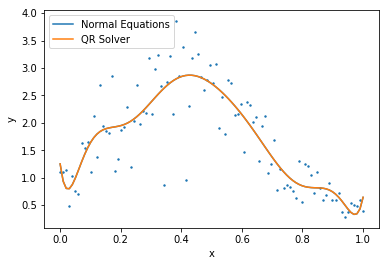

Forward Error for Normal Equation:  4.644312527551633
Forward Error for QR Decomposition:  4.644309587516279


In [280]:
prob5(10)

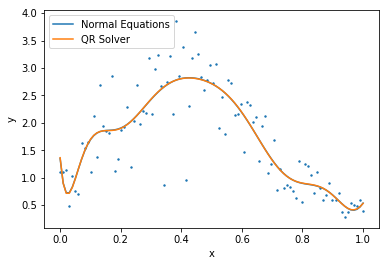

Forward Error for Normal Equation:  4.622195412497204
Forward Error for QR Decomposition:  4.622026000779455


In [282]:
prob5(11)

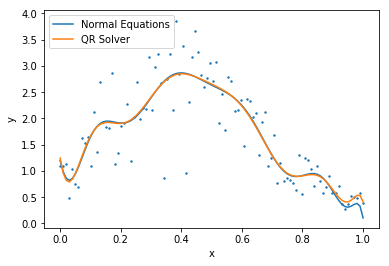

Forward Error for Normal Equation:  4.619518883734751
Forward Error for QR Decomposition:  4.593408026581487


In [283]:
prob5(12)

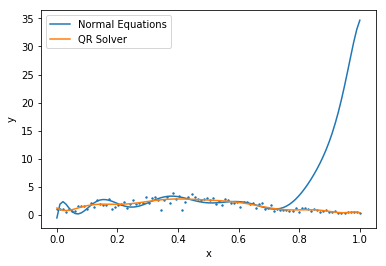

Forward Error for Normal Equation:  82.98911950130828
Forward Error for QR Decomposition:  4.593389524189638


In [284]:
prob5(13)

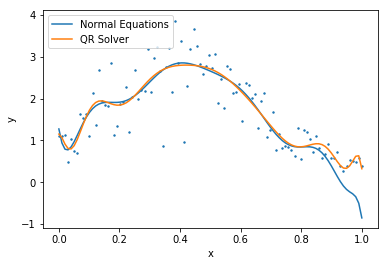

Forward Error for Normal Equation:  5.176708946589493
Forward Error for QR Decomposition:  4.568370943920144


In [285]:
prob5(14)

### Problem 6

In [293]:
def pob6():
    
    n_vals = np.arange(5, 51, 5, dtype=int)
    
    err_list = []
    for n in n_vals:
        
        x = sy.Symbol('x')
        I_1 = sy.integrate(x ** n * sy.exp(x - 1), (x, 0, 1))
        I_2 = (-1) ** n * sy.subfactorial(n) + ((-1) ** (n + 1)) \
                * (sy.factorial(n) / math.e)
        
        err = abs(I_1 - I_2)
        err_list.append(err)
    
    plt.plot(n_vals, err_list)
    plt.yscale('log')
    plt.ylabel("Relative Forward Error")
    plt.xlabel('n')
    plt.title('Relative Forward Error for Different n')
    plt.show()

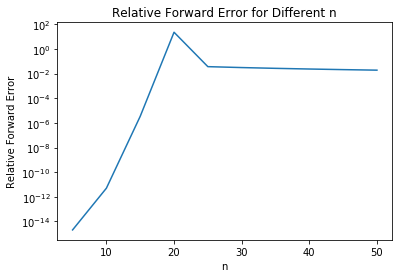

In [294]:
pob6()

#### (Comment) 
(10.6) does not seem to be a stable way to compute I(n) as the relative forward error increases exponentially. 